# Applied Data Science 2 - Keras Assignment - 2023A

In this assignment you will be building a script to classify movie posters. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

In [36]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection

In [37]:
# CodeGrade Tag Init1
# Do not edit, remove, or copy this cell

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing



In [38]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multi_Label_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multi_Label_dataset/Images /tmp/Multi_Label_dataset/

mkdir: cannot create directory ‘/tmp/Multi_Label_dataset’: File exists
              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/7868)   


In [39]:
# CodeGrade Tag DataProc
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/tmp/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [40]:
# CodeGrade Tag Ex1a
### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64, 64), and finally returns the image and labels.
def img_process(image, label):
    # Convert image data type to tf.float32
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image to [64, 64]
    image = tf.image.resize(image, [64, 64])

    return image, label




**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [41]:
# CodeGrade Tag Ex1b
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64. Use techniques like caching and
### prefetching to efficiently load the data.
# Training dataset
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Define a function to process the dataset
def process_dataset(ds):
    ds = ds.map(parse_image)
    ds = ds.map(img_process)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Apply the process_dataset function to the datasets
train_ds = process_dataset(train_list_ds)
test_ds = process_dataset(test_list_ds)

# Training dataset
train_ds = train_list_ds.map(parse_image).map(img_process).cache().batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Validation dataset
val_ds = test_list_ds.map(parse_image).map(img_process).cache().batch(64).prefetch(tf.data.experimental.AUTOTUNE)




# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [42]:
# CodeGrade Tag Ex2a
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Define input layer
inputs = Input(shape=(64, 64, 3), name='Input')

# Convolutional layers
conv0 = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv0')(inputs)
drop1 = Dropout(0.2, name='Drop1')(conv0)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(drop1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2')(conv1)
drop2 = Dropout(0.2, name='Drop2')(conv2)
pool1 = MaxPooling2D((2, 2), name='Pool1')(drop2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3')(pool1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv4')(conv3)
drop3 = Dropout(0.2, name='Drop3')(conv4)
pool2 = MaxPooling2D((2, 2), name='Pool2')(drop3)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv5')(pool2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv6')(conv5)
drop4 = Dropout(0.2, name='Drop4')(conv6)
pool3 = MaxPooling2D((2, 2), name='Pool3')(drop4)

# Flatten layer
flat = Flatten(name='Flat')(pool3)

# Fully connected layers
fc1 = Dense(1024, activation='relu', name='FC1')(flat)
drop5 = Dropout(0.5, name='Drop5')(fc1)
fc2 = Dense(1024, activation='relu', name='FC2')(drop5)
drop6 = Dropout(0.5, name='Drop6')(fc2)

# Output layer
outputs = Dense(25, activation='sigmoid', name='Output')(drop6)

# Define the model
model = Model(inputs=inputs, outputs=outputs)


# Define the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [43]:
# CodeGrade Tag Ex2b
### Print the model summary and confirm is has the same architecture as the one
### provided.

# Define the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()




Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 64, 64, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 64, 64, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 64, 64, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 32, 32, 32)        0   

**Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [44]:
# CodeGrade Tag Ex2c
### Compile the model using the Adam Optimizer, binary crossentropy loss, and
### precision and recall metrics.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])





# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [ ]:
# CodeGrade Tag Ex3a
### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/checkpoint'

# Create ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',        # Monitor validation loss
    save_weights_only=True,    # Save only the model weights
    mode='min',                # Save the model when the monitored metric is at its minimum
    save_best_only=True       # Save only the best model
)


**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
# CodeGrade Tag Ex3b
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

# Define the LearningRateScheduler callback
lr_callback = LearningRateScheduler(scheduler)

**Train the model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3c
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.
# Train the model for 40 epochs
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=40,
                    callbacks=[checkpoint_callback, lr_callback])



# Store the losses and metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']



Epoch 1/40
91/91 [==============================] - 148s 2s/step - loss: 0.3094 - precision: 0.3635 - recall: 0.2141 - val_loss: 0.3497 - val_precision: 0.5038 - val_recall: 0.2185 - lr: 1.0000e-04
Epoch 2/40
91/91 [==============================] - 140s 2s/step - loss: 0.2592 - precision: 0.4918 - recall: 0.1875 - val_loss: 0.3240 - val_precision: 0.5246 - val_recall: 0.2550 - lr: 1.0000e-04
Epoch 3/40
91/91 [==============================] - 137s 2s/step - loss: 0.2512 - precision: 0.5124 - recall: 0.1933 - val_loss: 0.3086 - val_precision: 0.5237 - val_recall: 0.2613 - lr: 1.0000e-04
Epoch 4/40
91/91 [==============================] - 138s 2s/step - loss: 0.2478 - precision: 0.5253 - recall: 0.1972 - val_loss: 0.3005 - val_precision: 0.5159 - val_recall: 0.2425 - lr: 1.0000e-04
Epoch 5/40
91/91 [==============================] - 136s 1s/step - loss: 0.2451 - precision: 0.5329 - recall: 0.1968 - val_loss: 0.2885 - val_precision: 0.5125 - val_recall: 0.2323 - lr: 1.0000e-04
Epoch 6/40

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

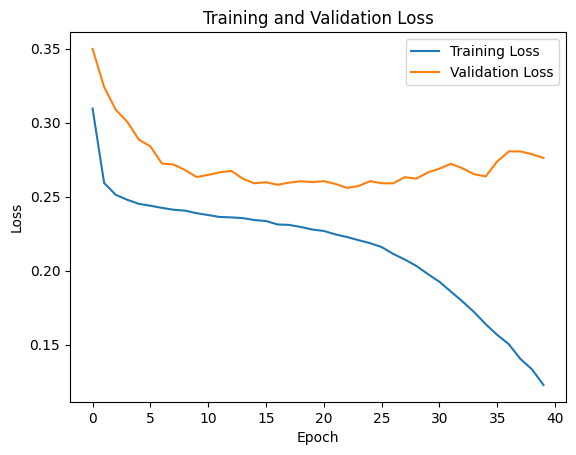

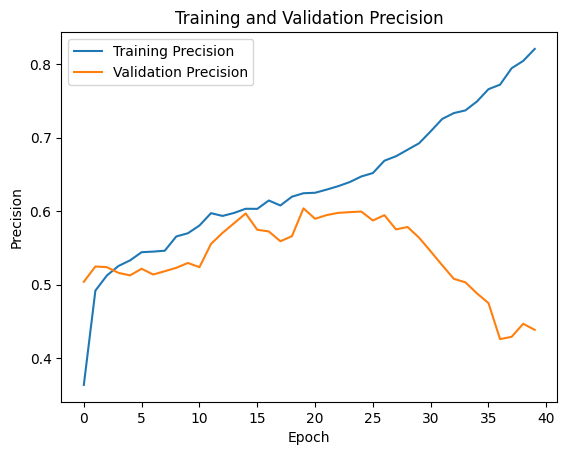

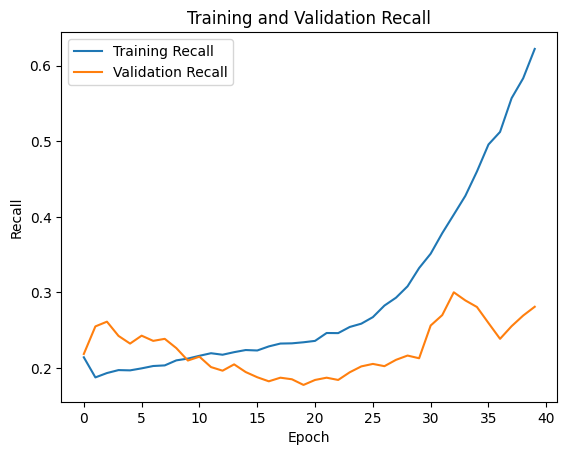

In [31]:
# CodeGrade Tag Ex4a
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

import matplotlib.pyplot as plt

# Plot training and validation precision
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()


**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce of the model. Be sure to demonstrate the results of the multi-label classification, comparing the top three most probable genres predicted with the ground truth genres for each poster. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

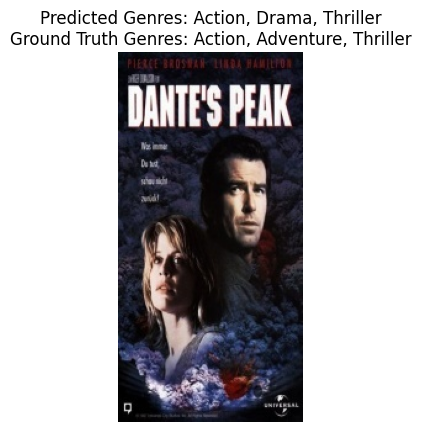

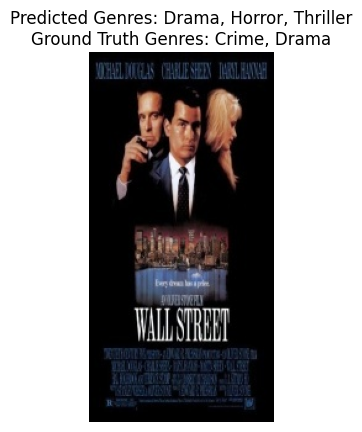

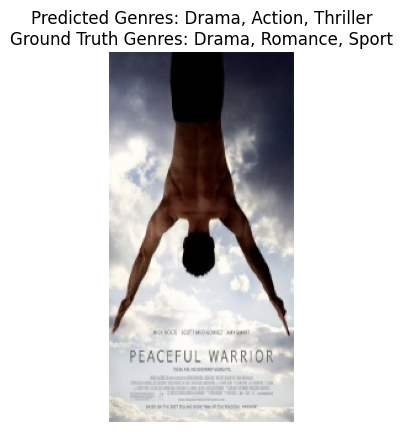

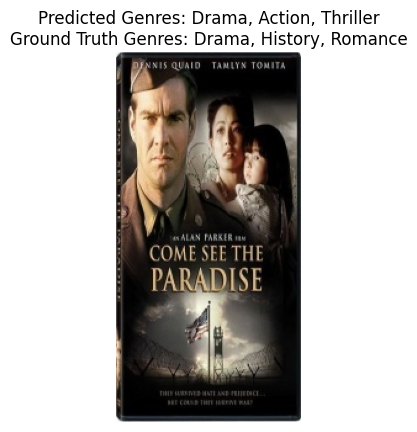

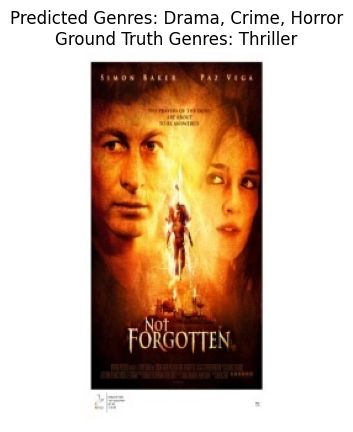

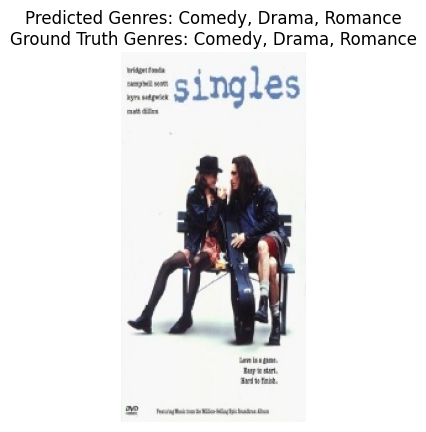

In [32]:
# Visualize the classification performance for 10 posters
for i in range(num_posters):
    # Get the poster image
    poster_path = img_locs_test[0][i]

    # Get the top three predicted genres
    predicted_genres = genres[top_three_predicted_genres[i]]

    # Get the ground truth genres
    true_genres = genres[np.where(ground_truth_genres[i] == 1)]

    # Visualize the classification performance for the current poster
    visualize_poster(poster_path, predicted_genres, true_genres)